# RAI Exercise 1: Algorithmic Fairness ⚖️

# Important information
This exercise is part of the RAI course (02517 - **Responsible AI: Algorithmic Fairness and Explainability**) at the Technical University of Denmark (DTU). You can find more details about the course [here](https://kurser.dtu.dk/course/02517). This specific version is for the Fall 2024 semester.

If you have any questions related to this notebook, feel free to reach out to Nina Weng at *ninwe@dtu.dk*.

**Credits**:  
We thank:
* NIH dataset team for collecting such dataset [link to the paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf);
* Authors from [this paper](https://link.springer.com/chapter/10.1007/978-3-031-45249-9_14) for providing the splits;
* [Memes generator webpage imgflip](https://imgflip.com/) for all the excellent Memes template.


# PART 1: Fairness assessment and Bias mitigation using Fairlearn

The goal of this exercise is to learn how to use [Fairlearn](https://fairlearn.org/) to approach basic fairness assessments and apply post-processing bias mitigation methods. 

Fairlearn is an open-source Python package originally developed by Microsoft Research. Since 2021, it has become completely community-driven. For more information about Fairlearn, you can visit [this page]((https://fairlearn.org/v0.10/about/index.html)). 

Although Fairlearn is likely the most well-developed package targeting fairness issues, it has its limitations. The most notable limitation, that might need to be mentioned at very beginning for this exercise, is that Fairlearn is primarily designed for tabular data ([this page](https://fairlearn.org/main/faq.html) under question: *Does Fairlearn work for image and text data?*). Therefore, when working with other types of data, such as image data, unexpected issues may arise. Fortunate enough, there are workarounds for most of these issues, which will be discussed later in this exercise.

While Fairlearn is a good resource and offers an easy approach for learning fairness concepts and handling lighter tasks, it may not be the best solution for researchers working extensively in this area. Keep that in mind :-)

## 🧠 Objective of this Exercise (PART 1)
By the end of this exercise, you should be able to:

* Assess fairness using Fairlearn with provided predictions/probabilities and target labels. This includes calculating metrics, generating ROC curves, and interpreting their meaning.
* Apply post-processing bias mitigation techniques using Fairlearn, and clearly understand and explain the outcomes.

![](./support4notebook/getstarted.jpg)

## 1. Dataset: Chest X-ray and lung/heart related disease


In this exercise, we will use a chest X-ray dataset and a basic deep learning model as the setup. It requires the following:

* Download the dataset/metadata/pretrained ResNet model. Note that in this exercise, we only use part of the data, and details are listed below. The full dataset can be found [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). (For students in the class, you can find a download link on DTU Learn. For those not in the class, you can find the pre-processing scripts in [this repository](https://github.com/nina-weng/detecting_causes_of_gender_bias_chest_xrays).)
* After downloading the materials, put the `NIH_train_val_test_rs0_f50.csv` under `./datafiles/`; and `nih_pneumothorax.pth` under `./pretrained_model/`.
* Prepare your virtual environment: 
`conda env create -f env.yml`


### Chest xray samples
We use [NIH chest xray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) in this exercise. Let’s take a closer look at the dataset. </br>

This dataset contains 108,948 images from 32,717 patients, each labeled with one of 14 types of lung or heart-related diseases/symptoms. For detailed information on each disease, you can find explanations [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/220660789610).

For simplicity, we will use only one sample per patient and preprocess the images to a size of 224x224. Both the dataset and the metadata (in CSV format) are available. The dataset split is also specified in the metadata under the column 'split'.

Note: The split was designed for a different task, which required a larger test set than usual. As a result (as you’ll notice), the test set is relatively large (around 8k for training, 2k for validation, and 8k for testing). If you find that the mitigation or prediction process takes too long, feel free to downsample the test set. Just ensure you validate that the proportions of samples across different sensitive groups and disease labels remain roughly consistent with the original test set.  

In [83]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import torch
import numpy as np
import json

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate, count    


from train.model import ResNet
from train.prediction import validate
from analysis.plot import plot_roc_simple

In [84]:
#TODO: change this to your data directory
datadir = '/Users/joaomata/Desktop/DTU/ResponsibleAI/02517_fairness_project/datafiles'

Let us take a look of some samples, with filter query. 

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,Effusion,Emphysema,Nodule,Atelectasis,Infiltration,...,Pneumothorax,Consolidation,Fibrosis,Cardiomegaly,Pneumonia,Edema,Hernia,No Finding,split,sex_label
0,00000041_002.png,41,62,F,PA,0,1,0,0,0,...,1,0,0,0,0,0,0,0,train,0
1,00000116_021.png,116,74,F,AP,1,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
2,00000211_023.png,211,59,F,PA,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
3,00000261_004.png,261,39,F,AP,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
4,00000416_005.png,416,67,F,PA,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0


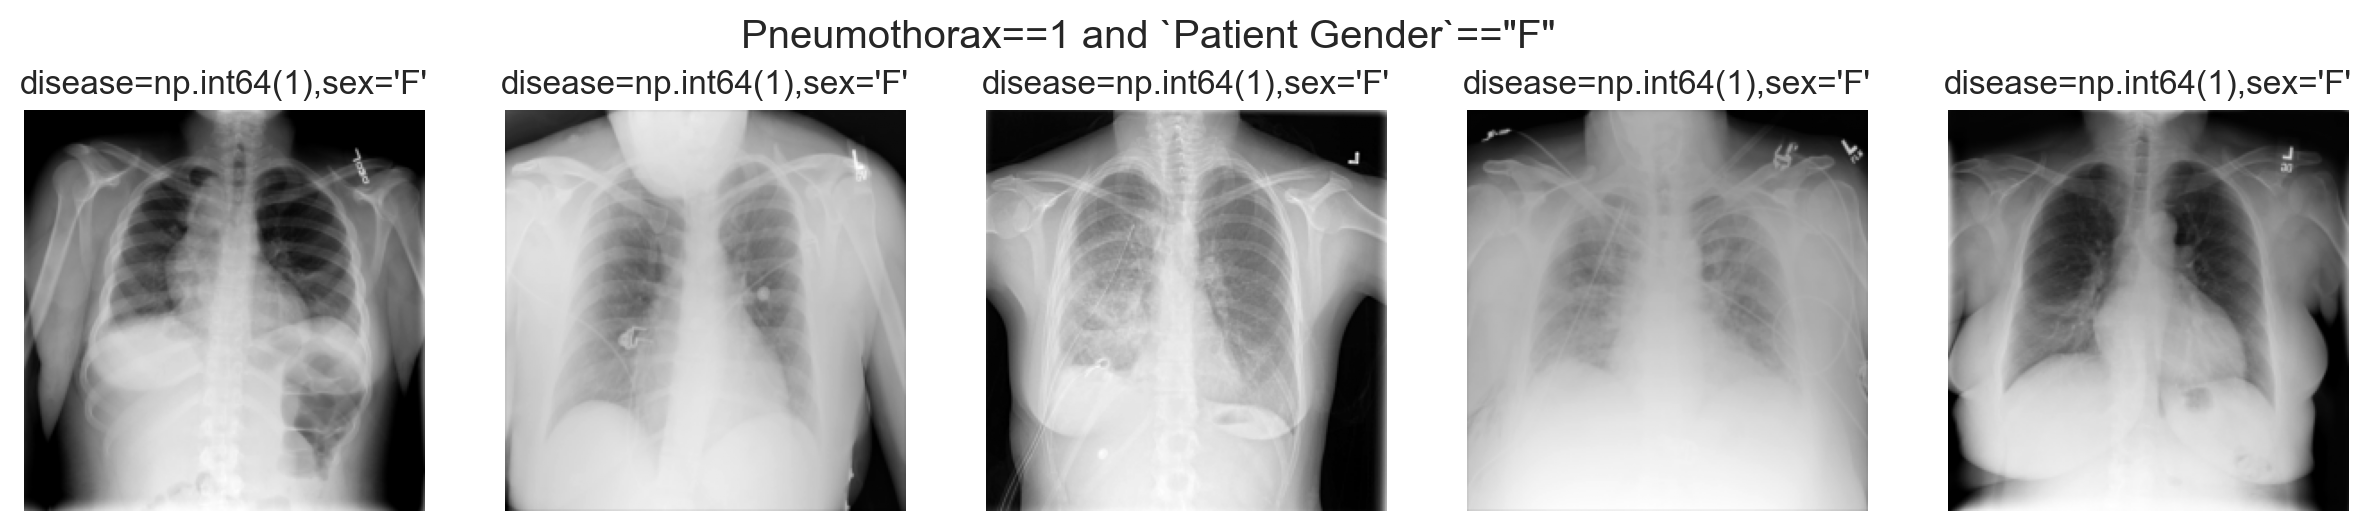

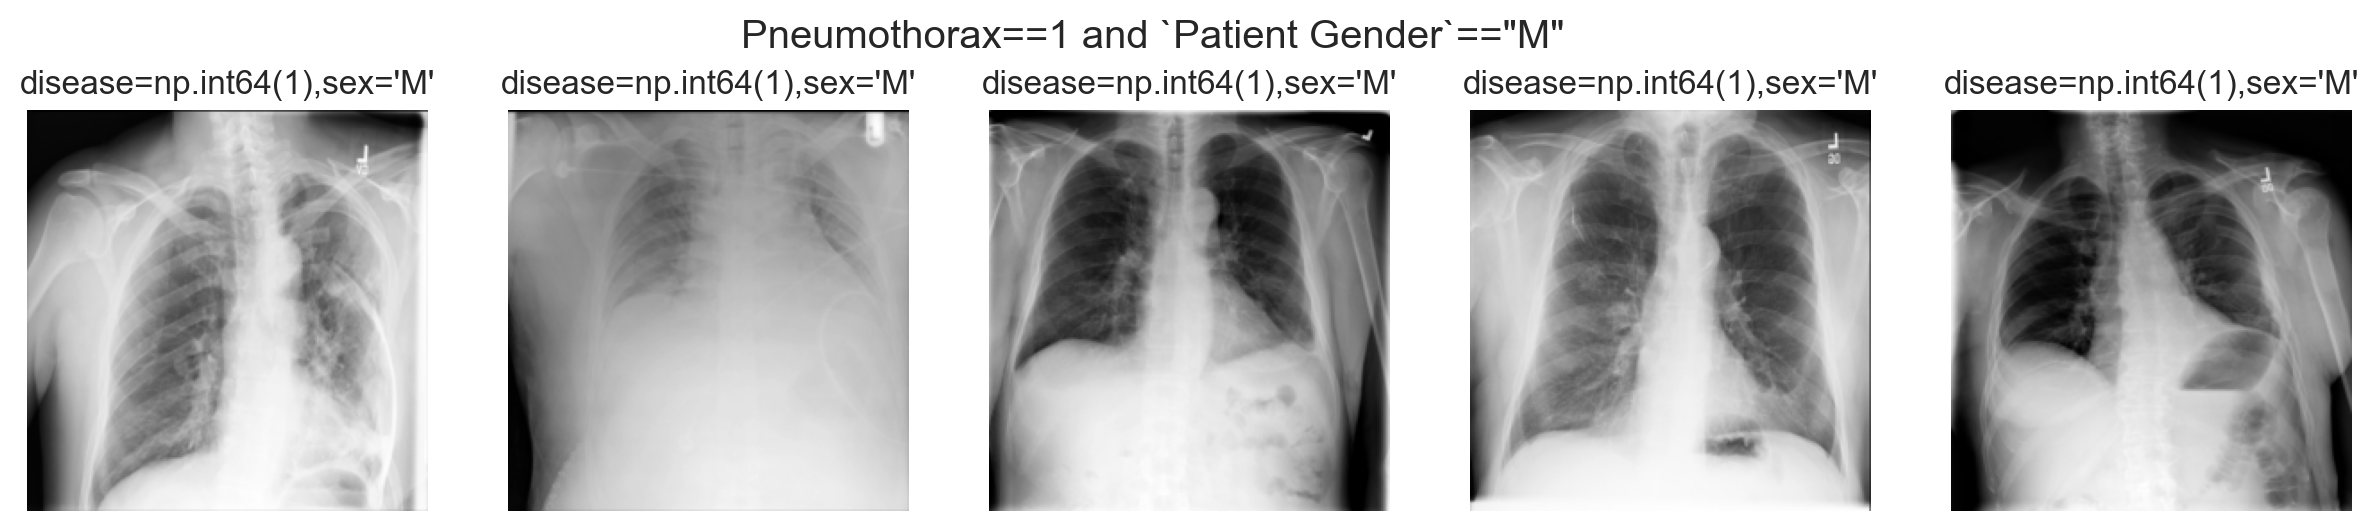

In [85]:
dataset_pth = datadir + '/NIH_part/'
metadata_csv ='./datafiles/NIH_train_val_test_rs0_f50.csv'
metadata = pd.read_csv(metadata_csv)

display(metadata.head(5))

# randomly choose some samples from PAD-UFES-20
def show_random_images(datadir,metadata,seed=None,filter_str=None,num_sample=5):
    fig = plt.figure(figsize=(num_sample*3, 3),dpi=200)
    files = os.listdir(datadir)
    if filter_str:
        metadata = metadata.query(filter_str)
        # display(metadata.head(5))
    if seed is not None:
        random_sample = metadata.sample(n=num_sample, random_state=seed)
    else: random_sample = metadata.sample(n=num_sample)
    
    for i in range(len(random_sample)):
        row = random_sample.iloc[i]
        disease = row['Pneumothorax']
        sex = row['Patient Gender']

        img = mpimg.imread(datadir + row['Image Index'])
        ax = fig.add_subplot(1, len(random_sample), i + 1)
        # add diagnosis as subtitle
        ax.set_title(f'{disease=},{sex=}')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle(f'{filter_str}')
    plt.show()

show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="F"',num_sample=5)
show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="M"',num_sample=5)

### Basic statistics

We can also take a look at the distribution of some sensitive attributes:

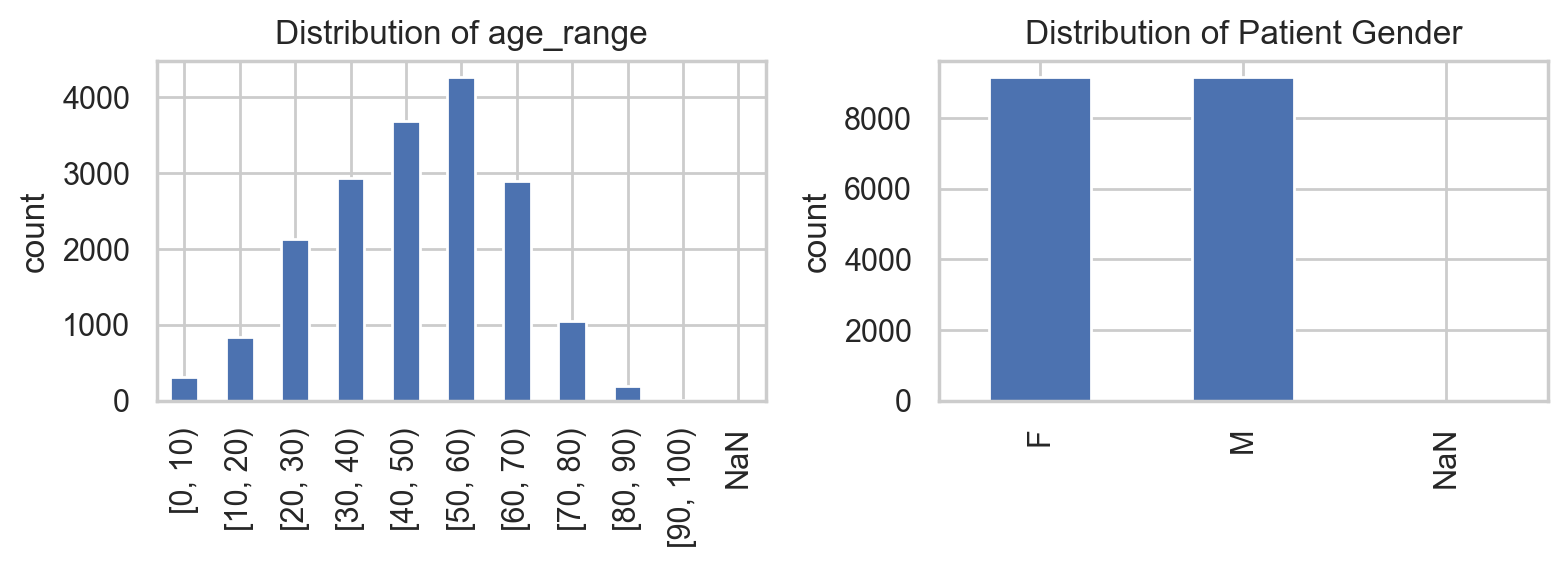

In [86]:
def plot_distribution_by_value(metadata, column_name):
    if isinstance(column_name, str):
        nan_count = metadata[column_name].isna().sum()
        nan_series = pd.Series([nan_count], index=['NaN'])
        counts_ = metadata[column_name].value_counts().sort_index()
        counts_with_nan = pd.concat([counts_, nan_series])

        counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(column_name))
        plt.ylabel('count')
    elif isinstance(column_name, list):
        fig, axes = plt.subplots( 1, len(column_name), figsize=( len(column_name)*4,3),dpi=200)
        for i,col in enumerate(column_name):
            nan_count = metadata[col].isna().sum()
            nan_series = pd.Series([nan_count], index=['NaN'])
            counts_ = metadata[col].value_counts().sort_index()
            counts_with_nan = pd.concat([counts_, nan_series])

            counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(col),ax=axes[i])
            axes[i].set_ylabel('count')
    plt.tight_layout()
    plt.show()

metadata['age_range'] = pd.cut(metadata['Patient Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], right=False)
plot_distribution_by_value(metadata, ['age_range','Patient Gender'])

You may have noticed that, for this specific split, we maintain an equal number of male and female samples. This balance is consistent across all three splits: training, validation, and testing.

### 📃 Further Reading:
If you're interested, here are some studies that explore potential biases and confounders in chest xray datasets:
* [Lauren Oakden-Rayner: Exploring the ChestXray14 dataset: problems](https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/)
* [Amelia Jiménez-Sánchez et al.: Detecting Shortcuts in Medical Images -- A Case Study in Chest X-rays](https://arxiv.org/abs/2211.04279)
* [Judy Wawira Gichoya et al.: AI recognition of patient race in medical imaging: a modelling study](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00063-2/fulltext)

## 2. Fairness assessment
**Recap of Key Concepts**:

In th class, we have learned:
* The three key criteria for fairness assessment. What are they?

    They are INDENDENCE, SEPARATION (EQUALIZED ODDS) AND SUFFICIENCY

* Evaluation metrics corresponding to each criterion.

    

* ROC curves.

For this exercise, we’ve provided a pre-trained ResNet classifier for Part 1, where the disease label is `Pneumothorax` and the sensitive attribute is `sex` (in metadata, you can get the binarized sex label from column `sex label`, where 0 represents female and 1 represents male). However, feel free to train your own model if you'd like.



### Load pretrained model

In [87]:
# load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # test
print(' device:', device)


ds_name = 'NIH'

# load the model
lr=1e-6
pretrained = True
model_scale = '18'
num_epochs =20
img_size = (1, 224, 224)

classifier = ResNet(num_classes=1, lr=lr, pretrained=pretrained, model_scale=model_scale, in_channel=img_size[0])

state_dict = torch.load('./pretrained_model/nih_pneumothorax.pth', map_location=torch.device('cpu'))
classifier.load_state_dict(state_dict)

#classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth'))
classifier.to(device)

classifier.eval()


 device: cpu


/Users/joaomata/Desktop/DTU/ResponsibleAI/02517_fairness_project/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joaomata/Desktop/DTU/ResponsibleAI/02517_fairness_project/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Load test and validation data

In [88]:
save_model_at = './pretrained_models/'

img_size = (1,224,224)
batch_size = 16

csv_pth = './datafiles/NIH_train_val_test_rs0_f50.csv' if ds_name == 'NIH' else None

disease_label = 'Pneumothorax' 
sensitive_label = 'sex'
augmentation = False

from train.train_chestxray import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(dataset_pth, 
                                                               ds_name,
                                                               csv_pth, 
                                                               image_size=img_size, 
                                                               device=device,
                                                               disease_label = disease_label,
                                                               sensitive_label = sensitive_label,
                                                               augmentation=augmentation)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we dont need it here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 8459/8459 [00:00<00:00, 24462.32it/s]


### Predict the results for both validation and test set

In [89]:
val_lab, val_pred, val_prob, val_a = validate(classifier, val_loader, device=device)
test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

100%|██████████| 89/89 [00:55<00:00,  1.60it/s]


val_loss=1.2286 val_acc=0.8211 val_auroc=0.7841


100%|██████████| 529/529 [07:53<00:00,  1.12it/s]

val_loss=1.2348 val_acc=0.8092 val_auroc=0.7726


If predicting on the validation/test set takes too long, you can simply load the pre-saved results directly from the CSV file. Note that if you use your own model, the results will differ from mine.

In [90]:
# # read the results from csv
# val_df = pd.read_csv('./datafiles/nih_val_results.csv')
# test_df = pd.read_csv('./datafiles/nih_test_results.csv')

# val_lab, val_pred, val_prob, val_a = val_df['val_lab'].values, val_df['val_pred'].values, val_df['val_prob'].values, val_df['val_a'].values
# test_lab, test_pred, test_prob, test_a = test_df['test_lab'].values, test_df['test_pred'].values, test_df['test_prob'].values, test_df['test_a'].values

### Assess fairness using Fairlearn
#### A simple example first

Fairlearn provides the `fairlearn.metrics.MetricFrame` class to help with this quantification. 

Given: 
<pre>
y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
           'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']
</pre>
           


![](./support4notebook/exercise_time.gif)

Try: 
* measure: recall, selection rate and false positive rate for *each group*;
* plot the above result out; ([Hint](https://fairlearn.org/main/user_guide/assessment/plotting.html))
* measure the difference in eqaulized odd between different groups;


Hint: The documentation page of [MetricFrame](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.MetricFrame.html#fairlearn.metrics.MetricFrame)

array([[<Axes: title={'center': 'recall'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

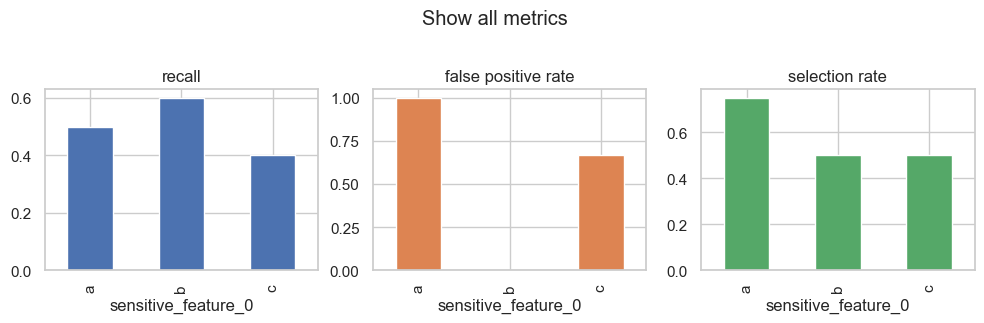

In [91]:
y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
           'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']

metrics = {
    "recall": true_positive_rate,
    "false positive rate": false_positive_rate,
    "selection rate": selection_rate,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sf_data
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


### Now measure the fairness metrics for our data

![](./support4notebook/exercise.jpg)

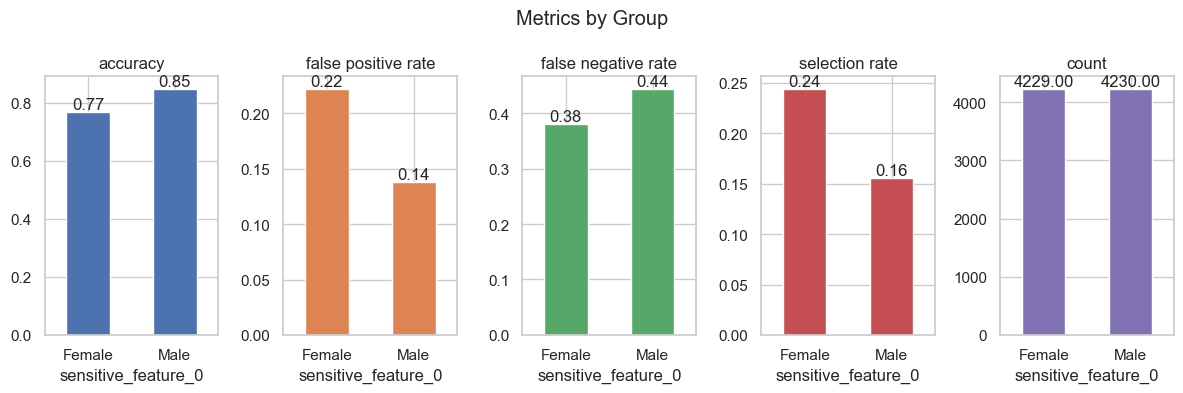

Test set fairness metrics (before mitigation):
                     accuracy  false positive rate  false negative rate  \
sensitive_feature_0                                                       
0.0                  0.769213             0.222028             0.380342   
1.0                  0.849173             0.137957             0.443820   

                     selection rate   count  
sensitive_feature_0                          
0.0                        0.244029  4229.0  
1.0                        0.155556  4230.0  


In [ ]:
import matplotlib.pyplot as plt

mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate, # FPR and FNR are useful for equalized odds (separation)
        "selection rate": selection_rate, # useful for demographic parity (independence)
        "count": count,
    },
    y_true=test_lab,
    y_pred=test_pred,
    sensitive_features=test_a
)

# Map sensitive feature values to group names
group_names = {0: "Female", 1: "Male"}
grouped = mf.by_group.rename(index=group_names)

# Plot bar charts
ax = grouped.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[12, 4],
    title="Metrics by Group",
)

# Add numbers on top of each bar
for a in ax.flatten():
    for p in a.patches:
        a.annotate(
            f'{p.get_height():.2f}',  # show value with 2 decimals
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom'
        )
    # Set horizontal x labels
    a.set_xticks(range(len(grouped.index)))
    a.set_xticklabels(grouped.index, rotation=0)

plt.tight_layout()
plt.show()

print("Test set fairness metrics (before mitigation):")
print(mf.by_group)


### Draw the ROC curve

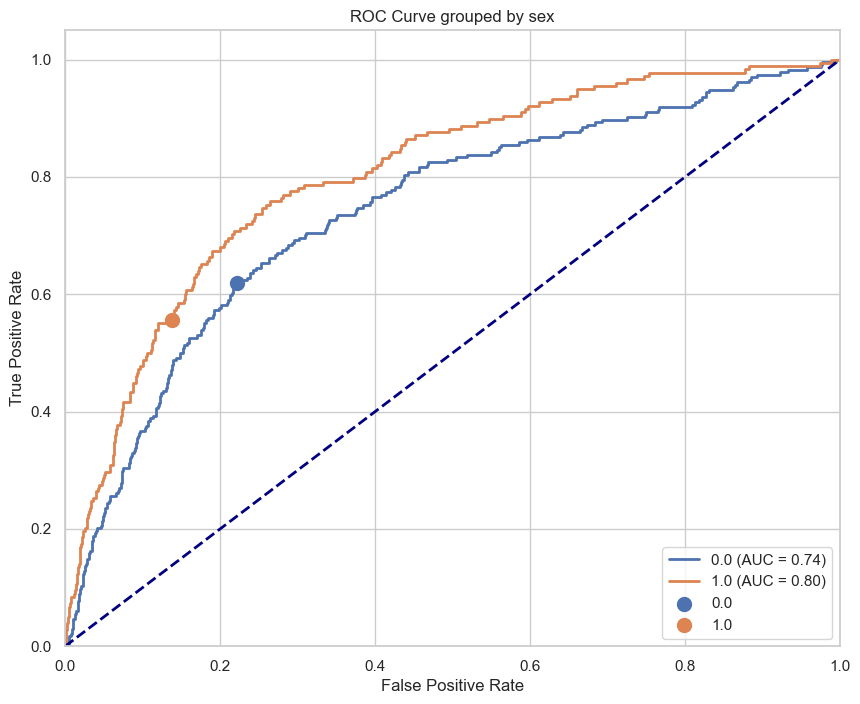

In [93]:
plot_roc_simple(test_lab, test_prob, test_a, test_pred,
        sensitive_attribute_name = 'sex',)

### 💥 Exercise and discusssion:
* What do you see from the metrics and the ROC curve?

    ROC Curves:
        
    Female (0.0): AUC = 0.74

    Male (1.0): AUC = 0.80

    The model discriminates better for males (higher AUC).

    Both ROC curves are above the diagonal, so the model is generally predictive for both groups.


* Try to measure and desribe the fairness with the 3 criterias we learned from class



## 3. Bias mitigation using Fairlearn

### Recall from the class
* what kinds of mitigation methods have we learned?

In this exercise, we will try to use the one pf the post-preprocessing bias mitiagtion method Fairlearn provided: **Threshold Optimization**, to implement the bias mitigation steps. 

### The theory of Threshold Optimization


The idea could be simply visualized as below (figure from the [original paper](https://arxiv.org/pdf/1610.02413)):  
![](./support4notebook/threshold_op.png)

Where blue/green represent two sensitive groups, any points in the overlapping region meet the requirement of equalized odds:

$$
\gamma_0(\hat{Y}) = \gamma_1(\hat{Y}),
$$

where 

$$
\gamma_a (\hat{Y}) = \left(Pr(\hat{Y} = 1 | A = a, Y = 0), Pr(\hat{Y} = 1 | A = a, Y=1)\right).
$$

The goal of the threshold optimizer is to find the point in the overlapping region that optimizes the objective function, such as balanced accuracy.

To achieve this, **randomization** is introduced. The idea is starightforward: any point under the ROC curve can be estimated by weighting two points on the ROC curve (which could be achieved by simply thresholding); or in another word, a new decision threshold $T_a$ can be a randomized mixture of two decision thresholds $\underline{t}_a$ and $\overline{t}_a$.

(See the figure below, which is from [this paper](https://arxiv.org/abs/2202.08536)).

![Randomization Figure](./support4notebook/randomization.png)


📃 Further Reading:
* [Fairlearn *ThresholdOptimizier* page](https://fairlearn.org/v0.5.0/api_reference/fairlearn.postprocessing.html).
* The original paper (See section 3): [Equality of opportunity in supervised learning](https://arxiv.org/pdf/1610.02413).




### 🪄 Trick: A fake classifier class

Fairlearn has some limitations when implementing the `ThresholdOptimizer` method. To work around these issues, a fake classifier is provided to bypass minor problems. If you use the provided classifier, this fake class should work just as well.

However, if you're curious about what went wrong or want to use your own classifier, please read below:

* **Problem 1: `estimator` in `ThresholdOptimizer` only accepts 2D input (tabular data).** This doesn’t make sense for post-processing mitigation methods, as the only relevant aspect here is the prediction scores from the test set. The classifier itself and the input data are irrelevant when optimizing the threshold.
  
* **Problem 2: The `prefit` parameter checks whether the model has been fitted in a simplistic way, leading to errors.** You can read more about this fit check function [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.validation.check_is_fitted.html).
  
* **Problem 3: It requires the prediction function to return scores for both classes in binary classification.** This might be an issue if your classifier only provides the probability for class 1.

**How we solve this**: We create a fake classifier called `IdentityClassifier`, which takes the pre-computed probabilities as input and simply returns them unchanged.

Note: If you trained your own classifier, you might need to change the following code a bit.

### Optimize on validation set

In [94]:
from sklearn.base import BaseEstimator, ClassifierMixin

class IdentityClassifier(BaseEstimator,ClassifierMixin):
    '''
    Fake classifier that takes 2D input, with pre-trained model that does not take 2D input data
    '''
    def __init__(self,):
        self.fit_ = True # fake the check_fit function inside the fairlearn library

    def fit(self,):
        # Do not need to fit
        return

    def predict(self, y_prob_2D, ):
        # predict function returns the index of the maximum probability for each sample
        assert len(y_prob_2D.shape) == 2, "Input should be 2D array, which contains probabilities for each class"
        return y_prob_2D.argmax(axis=1)
    
    def predict_proba(self, y_prob_2D):
        # predict_proba function returns the probabilities for each class
        assert len(y_prob_2D.shape) == 2, "Input should be 2D array, which contains probabilities for each class"
        return y_prob_2D

Your code here:

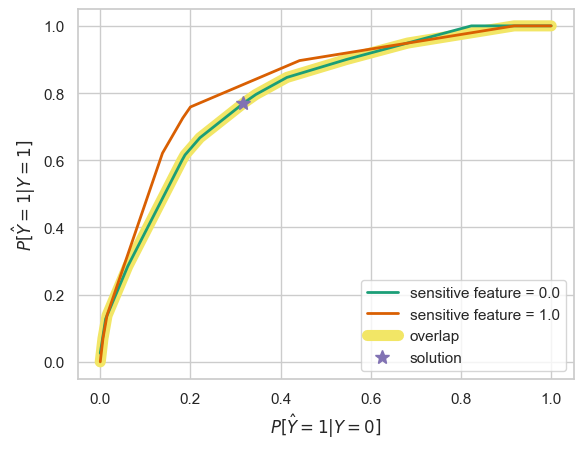

In [95]:
from fairlearn.postprocessing import plot_threshold_optimizer


val_prob = np.array(val_prob, dtype=np.float32)
val_prob_2D = np.column_stack((1 - val_prob, val_prob))

identityclf= IdentityClassifier()

# chhose an optimization method from farilearn, you can choose ThresholdOptimizer
from fairlearn.postprocessing import ThresholdOptimizer

updated_model = ThresholdOptimizer(
    estimator=identityclf,
    constraints="equalized_odds", 
    objective= "balanced_accuracy_score",
    predict_method='predict_proba',
    prefit=True)


# fit it with validation data

# Fit new model
#val_lab, val_pred, val_prob, val_a = validate(classifier, val_loader, device=device)
#test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

X = val_prob_2D
y = val_lab

updated_model.fit(X, y, sensitive_features=val_a)

# Print new fairness metrics with updated names for comparison
# fit it with validation data

plot_threshold_optimizer(updated_model)


### Use the new threshold for the test set

Your code here

In [96]:
# Make predictions
test_prob = np.array(test_prob, dtype=np.float32)
test_prob_2D = np.column_stack((1 - test_prob, test_prob))

# predict the test set using the fitted optimizer 
y_pred_fair_test = updated_model.predict(test_prob_2D, sensitive_features=test_a)

/Users/joaomata/Desktop/DTU/ResponsibleAI/02517_fairness_project/venv/lib/python3.12/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


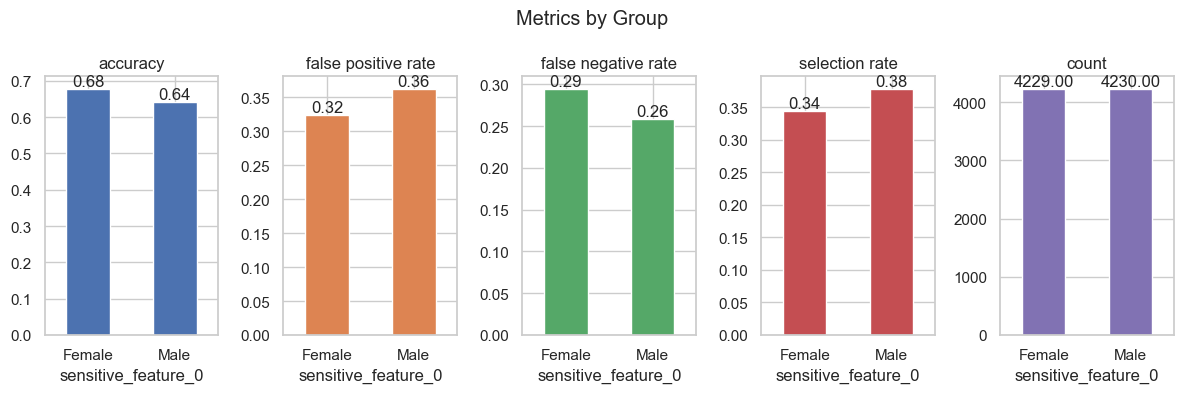

Test set fairness metrics (before mitigation):
                     accuracy  false positive rate  false negative rate  \
sensitive_feature_0                                                       
0.0                  0.677938             0.323655             0.294872   
1.0                  0.641844             0.362537             0.258427   

                     selection rate   count  
sensitive_feature_0                          
0.0                        0.344762  4229.0  
1.0                        0.378487  4230.0  


In [97]:
import matplotlib.pyplot as plt

mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=test_lab,
    y_pred=y_pred_fair_test,
    sensitive_features=test_a
)

# Map sensitive feature values to group names
group_names = {0: "Female", 1: "Male"}
grouped = mf.by_group.rename(index=group_names)

# Plot bar charts
ax = grouped.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[12, 4],
    title="Metrics by Group",
)

# Add numbers on top of each bar
for a in ax.flatten():
    for p in a.patches:
        a.annotate(
            f'{p.get_height():.2f}',  # show value with 2 decimals
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom'
        )
    # Set horizontal x labels
    a.set_xticks(range(len(grouped.index)))
    a.set_xticklabels(grouped.index, rotation=0)

plt.tight_layout()
plt.show()

print("Test set fairness metrics (before mitigation):")
print(mf.by_group)

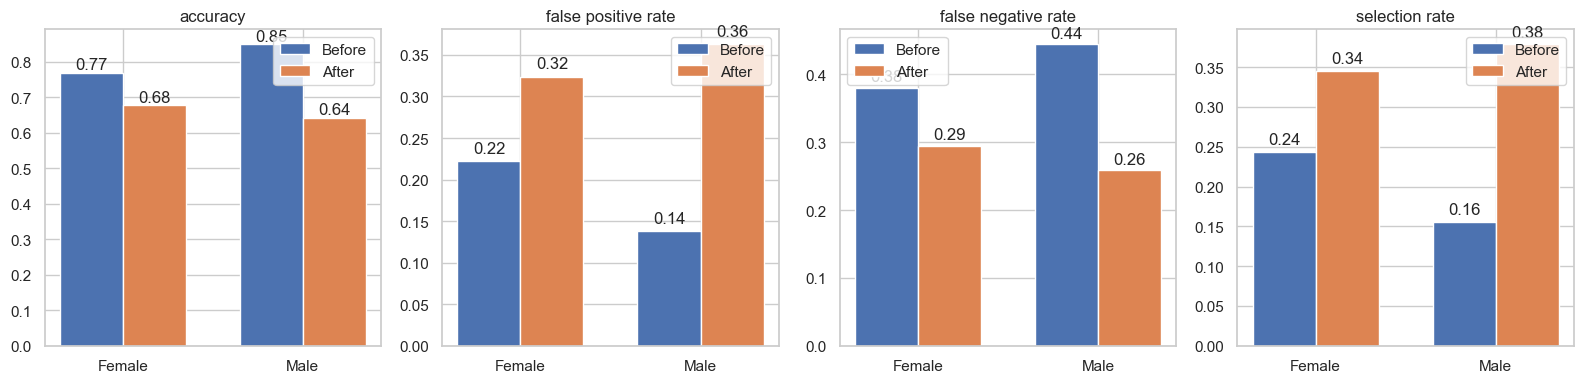

                     accuracy_before  false positive rate_before  \
sensitive_feature_0                                                
Female                      0.769213                    0.222028   
Male                        0.849173                    0.137957   

                     false negative rate_before  selection rate_before  \
sensitive_feature_0                                                      
Female                                 0.380342               0.244029   
Male                                   0.443820               0.155556   

                     count_before  accuracy_after  false positive rate_after  \
sensitive_feature_0                                                            
Female                     4229.0        0.677938                   0.323655   
Male                       4230.0        0.641844                   0.362537   

                     false negative rate_after  selection rate_after  \
sensitive_feature_0                  

In [104]:
import pandas as pd

# Before mitigation
mf_before = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=test_lab,
    y_pred=test_pred,
    sensitive_features=test_a
).by_group.rename(index={0: "Female", 1: "Male"})

# After mitigation
mf_after = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=test_lab,
    y_pred=y_pred_fair_test,
    sensitive_features=test_a
).by_group.rename(index={0: "Female", 1: "Male"})

combined = pd.concat(
    [mf_before.add_suffix('_before'), mf_after.add_suffix('_after')],
    axis=1
)


import matplotlib.pyplot as plt
import numpy as np

metrics = ["accuracy", "false positive rate", "false negative rate", "selection rate"]
groups = ["Female", "Male"]

x = np.arange(len(groups))
width = 0.35

fig, axes = plt.subplots(1, len(metrics), figsize=(16,4))

for i, metric in enumerate(metrics):
    axes[i].bar(x - width/2, combined[f"{metric}_before"], width, label='Before')
    axes[i].bar(x + width/2, combined[f"{metric}_after"], width, label='After')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(groups)
    axes[i].set_title(metric)
    axes[i].legend()
    # Add numbers on top
    for j in range(len(groups)):
        axes[i].text(x=j - width/2, y=combined[f"{metric}_before"].iloc[j]+0.01, 
                     s=f"{combined[f'{metric}_before'].iloc[j]:.2f}", ha='center')
        axes[i].text(x=j + width/2, y=combined[f"{metric}_after"].iloc[j]+0.01, 
                     s=f"{combined[f'{metric}_after'].iloc[j]:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Print the results as a table
print(combined)

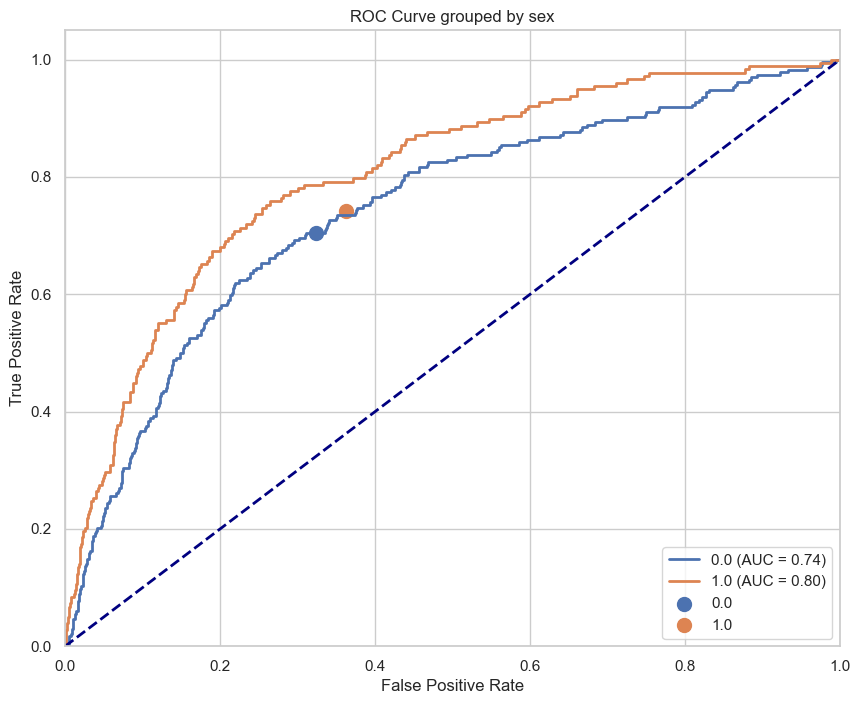

In [99]:
plot_roc_simple(test_lab, test_prob, test_a, y_pred_fair_test,
        sensitive_attribute_name = 'sex',)

### To find out how the prediction come from (the new threshold $T_a$)

In [100]:
threshold_rules_by_group = updated_model.interpolated_thresholder_.interpolation_dict
print(json.dumps(threshold_rules_by_group, default=str, indent=4))

{
    "0.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.317,
        "p0": 0.9932222222222229,
        "operation0": "[>0.30685366690158844]",
        "p1": 0.006777777777777105,
        "operation1": "[>0.2707943618297577]"
    },
    "1.0": {
        "p_ignore": 0.11022723354625812,
        "prediction_constant": 0.317,
        "p0": 0.5154907975460122,
        "operation0": "[>0.24994368851184845]",
        "p1": 0.48450920245398776,
        "operation1": "[>0.06453442946076393]"
    }
}


### 💥 Exercise and Discussion:
* Can you write down the new threshold function? ([Hint](https://fairlearn.org/v0.10/user_guide/mitigation/postprocessing.html#postprocessing))
* Compare the results. What do you observe, and does this model seem fair to you?
* Hint: After optimization, you may notice that accuracy (or other metrics) is more balanced between groups. However, the overall accuracy (or other metrics of interest) may decrease for both groups. Do you think this is still a good or acceptable solution?


![](./support4notebook/dilemma.jpg)

# PART 2: Potential pitfall: Algorithmic fairness in the presence of label noise
As mentioned in class, it is easy to diagnose algorithmic bias. This is, however, only true if we have access to correct target labels for the test set. In this part of the project, we will simulate a situation where our test set ground truth target labels are incorrect in a biased way: You will simulate overdiagnosis among male individuals, by manually distorting some of their labels. Next, you will analyze how this affects the diagnosis and mitigation of algorithmic bias.

## Write a script to distort the labels for the male individuals according to the following recipe:
* Please create a new set of distorted target labels
* Initialize these as identical to the supplied target labels
* Manually distort them by flipping 30% of the healthy labels for male individuals to diseased. These should be selected at random.

## Now repeat your analysis from Part 1 for your classifier from Part 1 using the distorted labels. 
You don’t need to retrain the classifier – you will only repeat the diagnosis and mitigation parts.

* Diagnose algorithmic bias with respect to your distorted labels. Do your conclusions change?
* Mitigate algorithmic bias with respect to your distorted labels. Following this, repeat your diagnostic pipeline both with respect to your distorted and original labels. What do you see? Did mitigation ensure improved fairness with respect to the distorted labels? What happened with respect to the actual (original) labels? Is the mitigated algorithm actually fair?





![](./support4notebook/dataset.jpg)

# Code for part 2

Simulating a situation where the ground truth labels are incorrect in a biased way

## Flipped 30% of healthy man to diseased 
### Flipping the *test* set
(target variable from 0 to 1)

Original distribution of labels: [8047  412] (0: healthy, 1: diseased)
Flipped 1215 male healthy labels to diseased to simulate biased ground truth labels
New distribution of labels: [6832 1627] (0: healthy, 1: diseased)


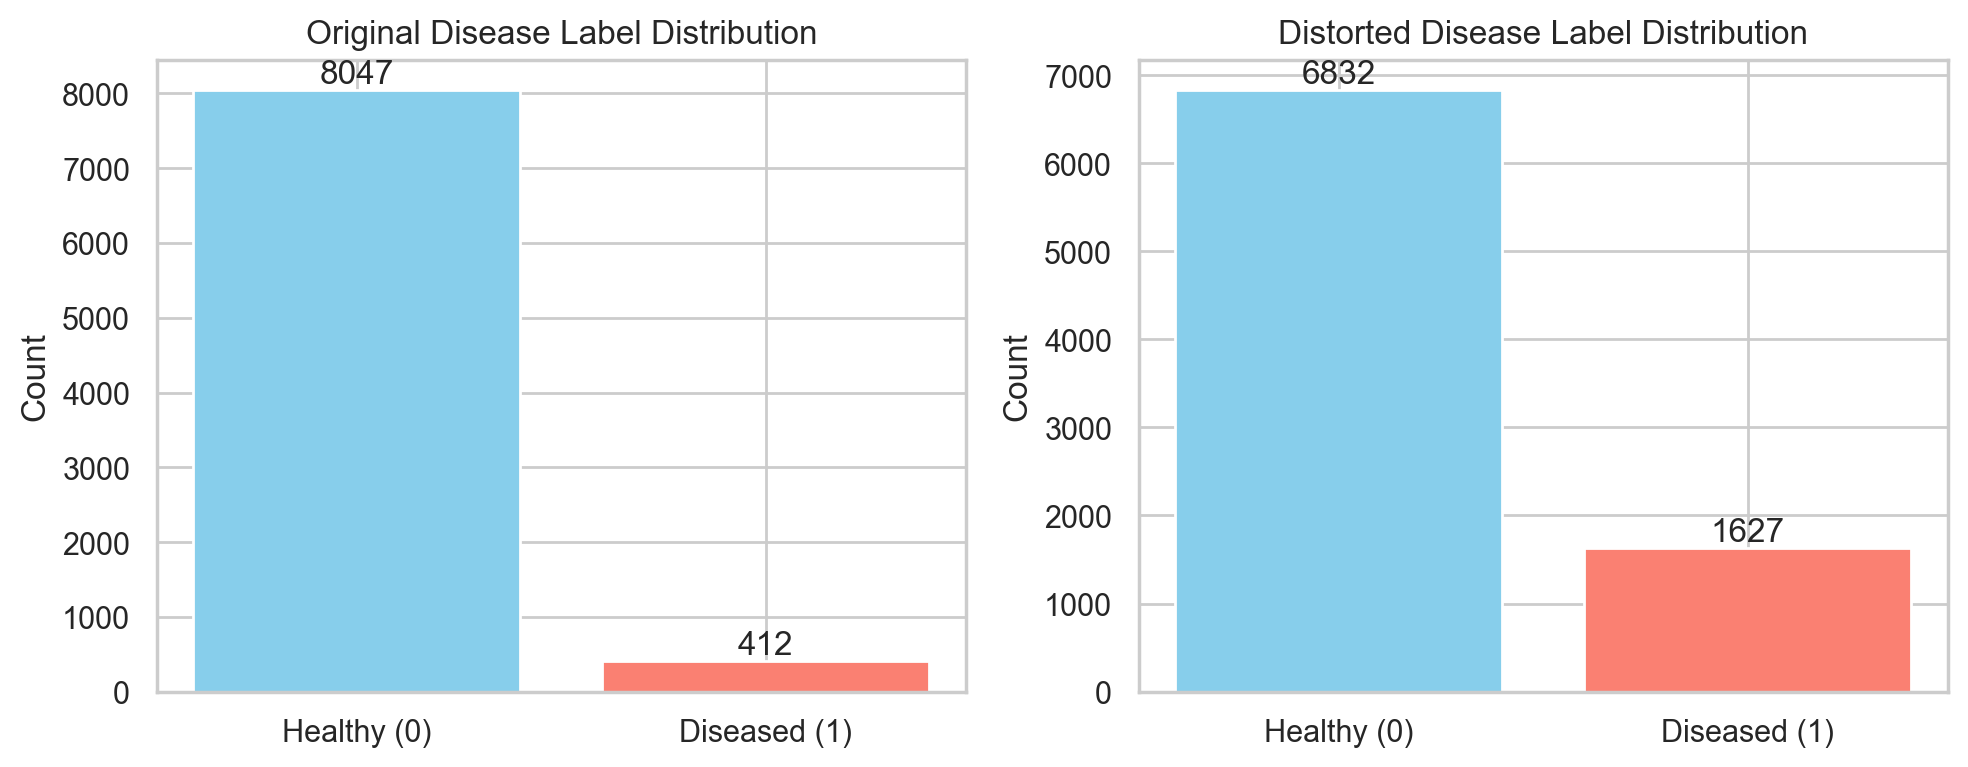

In [130]:
# Ensure numpy arrays
test_lab_np = np.array(test_lab)
test_a_np   = np.array(test_a)

# Ensure numpy int arrays
test_lab_np = np.array(test_lab).astype(int)
test_a_np   = np.array(test_a).astype(int)

# Copy labels
distorted_target_labels = test_lab_np.copy()

print(f"Original distribution of labels: {np.bincount(distorted_target_labels)} (0: healthy, 1: diseased)")

# Indices of male (1) AND healthy (0)
male_healthy_idx = np.where((test_a_np == 1) & (test_lab_np == 0))[0]

# Flip 30% of them
np.random.seed(42)
num_to_flip = int(0.3 * len(male_healthy_idx))
indices_to_flip = np.random.choice(male_healthy_idx, size=num_to_flip, replace=False)

# Apply flip
distorted_target_labels[indices_to_flip] = 1

print(f"Flipped {num_to_flip} male healthy labels to diseased to simulate biased ground truth labels")
print(f"New distribution of labels: {np.bincount(distorted_target_labels)} (0: healthy, 1: diseased)")


## USED CHATGPT TO GENERATE THE PLOT BELOW
# Plot before and after of the disease label distribution   
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
bars0 = axes[0].bar(['Healthy (0)', 'Diseased (1)'], np.bincount(test_lab_np), color=['skyblue', 'salmon'])
axes[0].set_title('Original Disease Label Distribution')
axes[0].set_ylabel('Count')
for bar in bars0:
    axes[0].annotate(f'{int(bar.get_height())}', 
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                     ha='center', va='bottom')
bars1 = axes[1].bar(['Healthy (0)', 'Diseased (1)'], np.bincount(distorted_target_labels), color=['skyblue', 'salmon'])
axes[1].set_title('Distorted Disease Label Distribution')
axes[1].set_ylabel('Count')
for bar in bars1:
    axes[1].annotate(f'{int(bar.get_height())}', 
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                     ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Running the usual fairness metrics

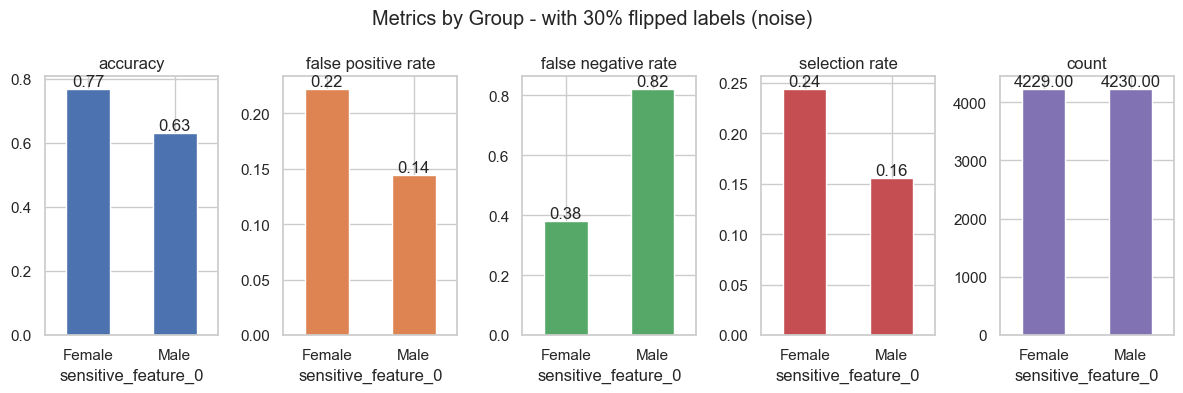

Test set fairness metrics (before mitigation):
                     accuracy  false positive rate  false negative rate  \
sensitive_feature_0                                                       
0.0                  0.769213             0.222028             0.380342   
1.0                  0.632388             0.144519             0.821967   

                     selection rate   count  
sensitive_feature_0                          
0.0                        0.244029  4229.0  
1.0                        0.155556  4230.0  


In [129]:
import matplotlib.pyplot as plt

mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=distorted_target_labels,
    y_pred=test_pred,
    sensitive_features=test_a
)

# Map sensitive feature values to group names
group_names = {0: "Female", 1: "Male"}
grouped = mf.by_group.rename(index=group_names)

# Plot bar charts
ax = grouped.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[12, 4],
    title="Metrics by Group - with 30% flipped labels (noise)",
)

# Add numbers on top of each bar
for a in ax.flatten():
    for p in a.patches:
        a.annotate(
            f'{p.get_height():.2f}',  # show value with 2 decimals
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom'
        )
    # Set horizontal x labels
    a.set_xticks(range(len(grouped.index)))
    a.set_xticklabels(grouped.index, rotation=0)

plt.tight_layout()
plt.show()

print("Test set fairness metrics (before mitigation):")
print(mf.by_group)

## Using threshold Optimizer to mitigate bias
### For that we need to also flip the 30% of the *validation* set, because we need to use it for the optimizationn step

Original validation distribution: [1341   68]
Distorted validation distribution: [1139  270]


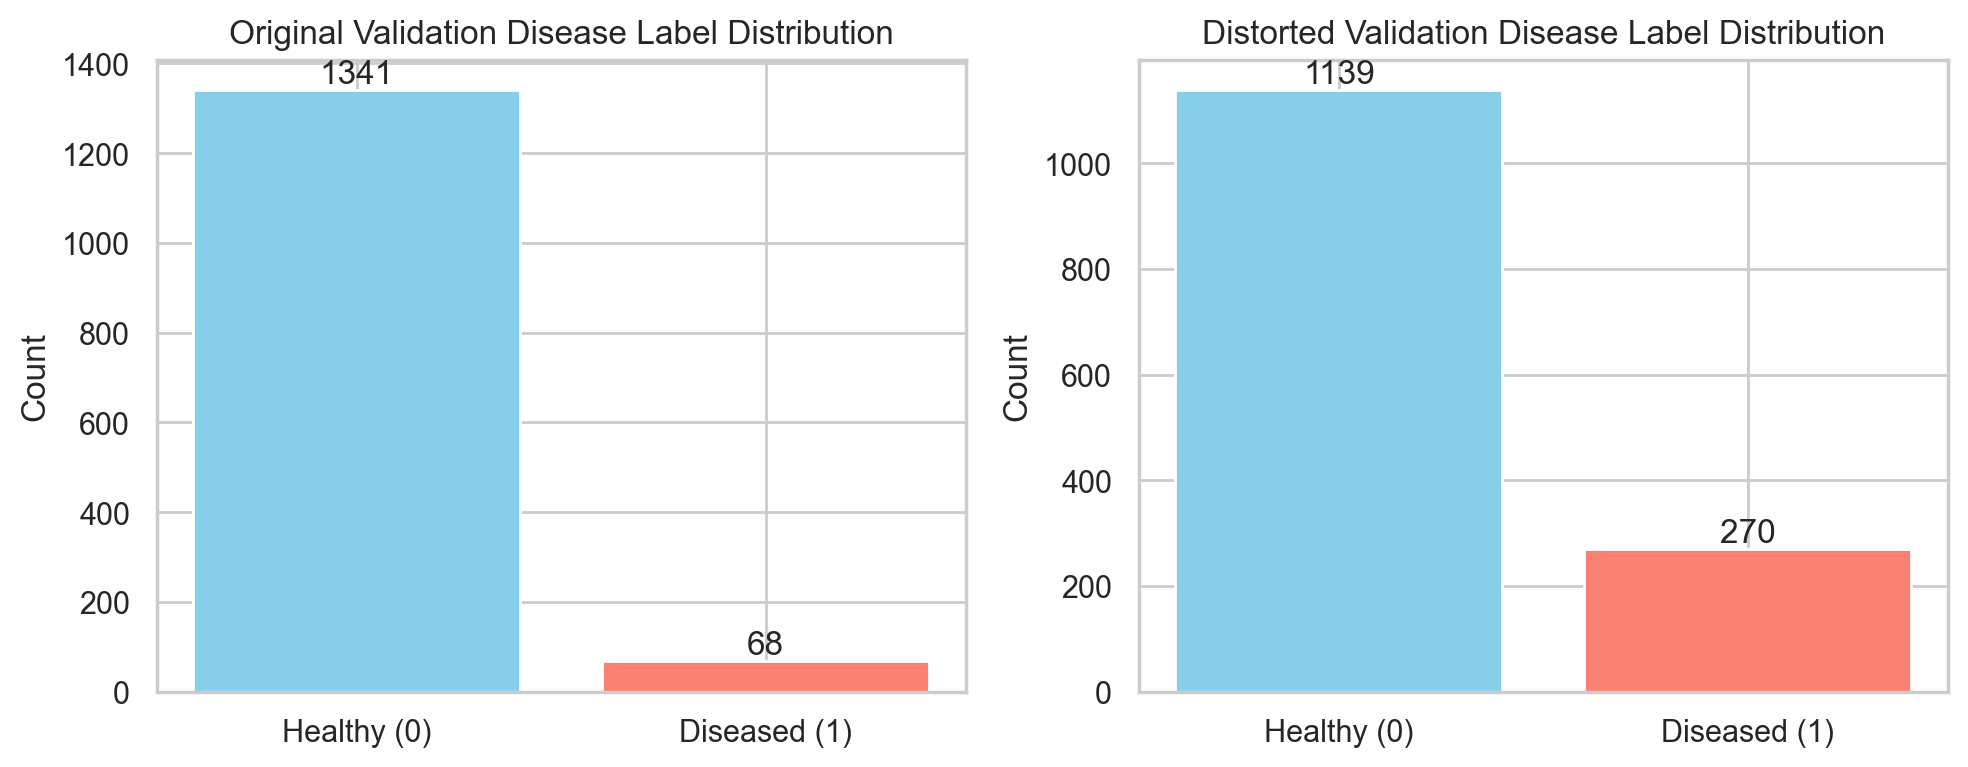

In [131]:
# To use threshold optimizer, we need to distort the validation labels in the same way

def distort_male_labels(y, sensitive, flip_frac=0.3, seed=42):
    y_distorted = y.copy()
    rng = np.random.default_rng(seed)
    male_healthy_idx = np.where((sensitive == 1) & (y == 0))[0]
    n_flip = int(len(male_healthy_idx) * flip_frac)
    flip_idx = rng.choice(male_healthy_idx, size=n_flip, replace=False)
    y_distorted[flip_idx] = 1
    return y_distorted

# Ensure numpy arrays for validation
val_lab_np = np.array(val_lab).astype(int)
val_a_np   = np.array(val_a).astype(int)

# Distort validation labels (males 0 → 1, 30%)
distorted_val_labels = distort_male_labels(val_lab_np, val_a_np, flip_frac=0.3)

print("Original validation distribution:", np.bincount(val_lab_np))
print("Distorted validation distribution:", np.bincount(distorted_val_labels))


# USED CHATGPT TO GENERATE THE PLOT BELOW
# Plot the valdiation labels
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
bars0 = axes[0].bar(['Healthy (0)', 'Diseased (1)'], np.bincount(val_lab_np), color=['skyblue', 'salmon'])
axes[0].set_title('Original Validation Disease Label Distribution')
axes[0].set_ylabel('Count')
for bar in bars0:
    axes[0].annotate(f'{int(bar.get_height())}', 
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                     ha='center', va='bottom')
bars1 = axes[1].bar(['Healthy (0)', 'Diseased (1)'], np.bincount(distorted_val_labels), color=['skyblue', 'salmon'])
axes    [1].set_title('Distorted Validation Disease Label Distribution')
axes[1].set_ylabel('Count')
for bar in bars1:
    axes[1].annotate(f'{int(bar.get_height())}', 
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                     ha='center', va='bottom')
plt.tight_layout()
plt.show()


### plotting the  new threshold

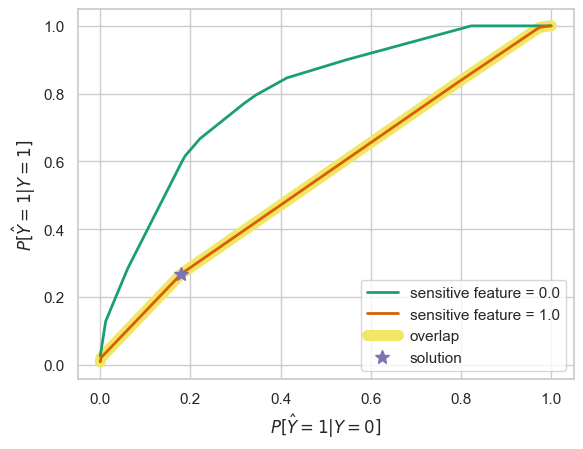

In [132]:
# Use distorted validation labels instead of true ones
y_val_distorted = distorted_val_labels 
X = val_prob_2D

updated_model_distorted = ThresholdOptimizer(
    estimator=identityclf,
    constraints="equalized_odds",
    objective="balanced_accuracy_score",
    predict_method="predict_proba",
    prefit=True
)

updated_model_distorted.fit(X, y_val_distorted, sensitive_features=val_a)
plot_threshold_optimizer(updated_model_distorted)


## Using the mitigated model (with noise) to predict in the test set

In [134]:
# Use the mitigated (after noise) model to predict the test set

test_prob_2D = np.column_stack((1 - test_prob, test_prob))
y_pred_fair_distorted = updated_model_distorted.predict(test_prob_2D, sensitive_features=test_a)


/Users/joaomata/Desktop/DTU/ResponsibleAI/02517_fairness_project/venv/lib/python3.12/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35451986 0.14169076 0.14169076 ... 0.14169076 0.14169076 0.14169076]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


## Plotting fairness metrics

### to se eif teh mitigation improved the damage caused by the noise

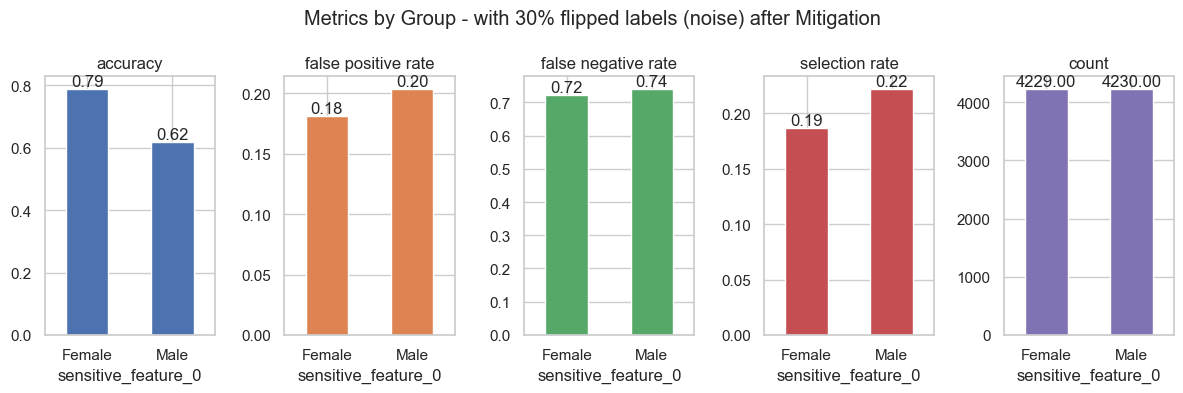

Test set fairness metrics (before mitigation):
                     accuracy  false positive rate  false negative rate  \
sensitive_feature_0                                                       
0.0                  0.789075             0.180976             0.722222   
1.0                  0.619385             0.203736             0.740847   

                     selection rate   count  
sensitive_feature_0                          
0.0                        0.186332  4229.0  
1.0                        0.221986  4230.0  


In [136]:
import matplotlib.pyplot as plt

mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=distorted_target_labels,
    y_pred=y_pred_fair_distorted,
    sensitive_features=test_a
)

# Map sensitive feature values to group names
group_names = {0: "Female", 1: "Male"}
grouped = mf.by_group.rename(index=group_names)

# USED CHATGPT TO GENERATE THE PLOT BELOW   
# Plot bar charts
ax = grouped.plot.bar(
    subplots=True,
    layout=[1, 5],
    legend=False,
    figsize=[12, 4],
    title="Metrics by Group - with 30% flipped labels (noise) after Mitigation",
)

# Add numbers on top of each bar
for a in ax.flatten():
    for p in a.patches:
        a.annotate(
            f'{p.get_height():.2f}',  # show value with 2 decimals
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom'
        )
    # Set horizontal x labels
    a.set_xticks(range(len(grouped.index)))
    a.set_xticklabels(grouped.index, rotation=0)

plt.tight_layout()
plt.show()

print("Test set fairness metrics (before mitigation):")
print(mf.by_group)

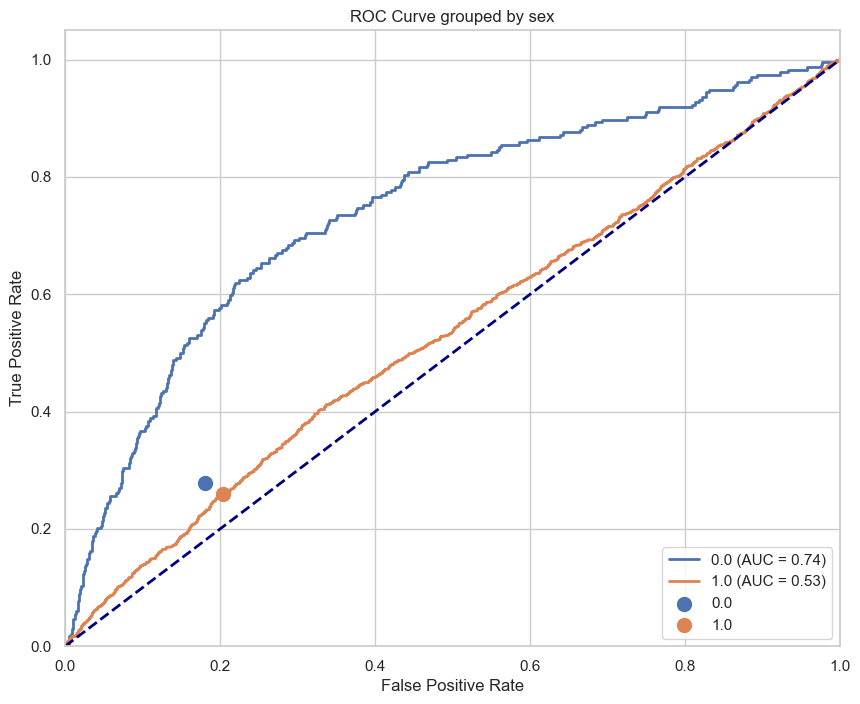

In [147]:
plot_roc_simple(distorted_target_labels, test_prob, test_a, y_pred_fair_distorted,
        sensitive_attribute_name = 'sex',)

In [148]:
!jupyter nbconvert --to html "exercise.ipynb"


110840.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[NbConvertApp] Converting notebook exercise.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 2247083 bytes to exercise.html
